In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# You can set this to true to make the delays a "triangle"
OVERRIDE_WITH_LINEAR_DELAYS=False

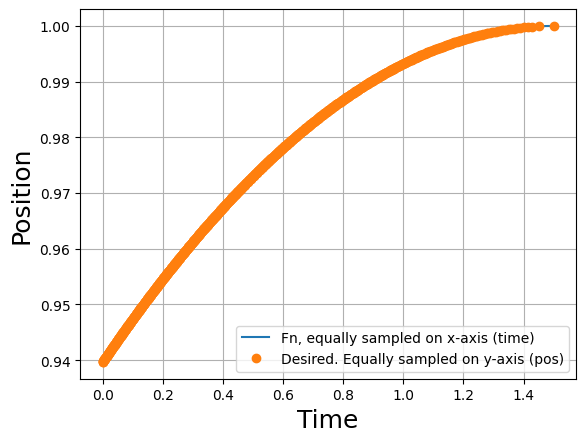

In [3]:
# Enter parameters here:

# Time (seconds)
t_max=1.5            # time (seconds) to get from min to max position
angle_start_deg=20   # -angle to start (will go to zero and back)
num_steps=900         # Number of stepper motor steps to traverse #800

t=np.linspace(0,t_max) # # of items doesn't matter here, just for plot
desired_pos=cos( t/t_max*np.radians(angle_start_deg))

plt.plot(t_max-t,desired_pos, '-', label='Fn, equally sampled on x-axis (time)' )

plt.xlabel('Time',size=18)
plt.ylabel('Position',size=18)
plt.grid()

# But it's really equal samples of the y-axis that is needed.
# So, invert the function above. Take the arccos of both sides.
# arccos(desired_pos) = t/t_max*np.radians(20)

steps=np.linspace(1,np.cos(radians(angle_start_deg)),num_steps-1)
t_desired = arccos(steps) * t_max / np.radians(angle_start_deg)

plot(t_max-t_desired,steps,'o', label='Desired. Equally sampled on y-axis (pos)')
legend(loc='best')

In [4]:
# So, the time needed are the diffs of t_desired.
# Also, need to flip the x-order. Start fast, then slow down in middle

In [5]:
delays=np.diff(-t_desired[::-1]) * 1000000

if OVERRIDE_WITH_LINEAR_DELAYS:
    delays=np.linspace(1346,43919,num_steps)
    
intervals_usec = delays

# Scale the intervals to uint8 for the table, going from 0-254 (linear)
# We lose precision, of course, but hopefully with rounding are
# still close to the desired behavior.

#INTERVAL_TABLE_MAX=254.0 # uint8, from 0-254
#INTERVAL_TABLE_MAX=2**16 # uint16 max
INTERVAL_TABLE_MAX=np.max(delays)-np.min(delays) # By doing this, we make scaler=1 (don't need to divide anything with 16bits)

expander_exponent=0
# To get a more accurate int, multiply/divide by this (2k)
# Start at 0, see if the maximum interval is better than precision
# If so, increment expander until it's okay

interval_min=np.round( np.min(intervals_usec) )
interval_max=np.max(intervals_usec)
scaler=((interval_max-interval_min)/INTERVAL_TABLE_MAX)
scaler_expanded=np.round( scaler*(2**expander_exponent) )
if scaler==0: scaler=1 # For constants scalar might be 0

intervals =np.round( (intervals_usec-interval_min)/scaler_expanded )
intervals_recon = np.array(
    intervals * scaler_expanded + interval_min, dtype=int)

print("Num Steps: %d"%(num_steps) )
print("Sum time recon.: %f sec"%np.sum(intervals_recon/1000000) )
print()
print("Desired: %08.1f %08.1f"%(interval_min, interval_max))
print("InTable: %08.1f %08.1f"%(np.min(intervals), np.max(intervals)))
print("Scaler expanded: %d"%scaler_expanded)
print("Expander exponent: %d (unused?)"%expander_exponent)
print()
print( intervals[0:5], intervals[-5:])
print( intervals_recon[0:5], intervals_recon[-5:] )
print( delays[0:5], delays[-5:])

Num Steps: 900
Sum time recon.: 1.499995 sec

Desired: 000844.0 049802.2
InTable: 000000.0 048958.0
Scaler expanded: 1
Expander exponent: 0 (unused?)

[0. 0. 1. 1. 2.] [10914. 12501. 14986. 19785. 48958.]
[844 844 845 845 846] [11758 13345 15830 20629 49802]
[844.0021002  844.45807138 844.91481503 845.37233332 845.83062843] [11757.52143082 13345.16169418 15829.56016437 20629.13399826
 49802.18344634]


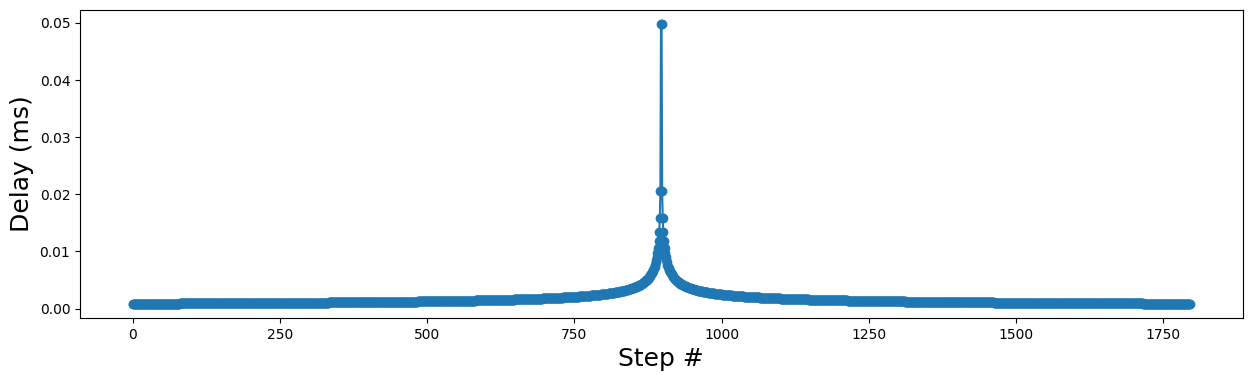

In [6]:
plt.figure(figsize=(15,4))
plt.plot( ( np.concatenate((delays/1000000, delays[::-1]/1000000))),'o-')
plt.xlabel('Step #', size=18)
plt.ylabel('Delay (ms)', size=18);

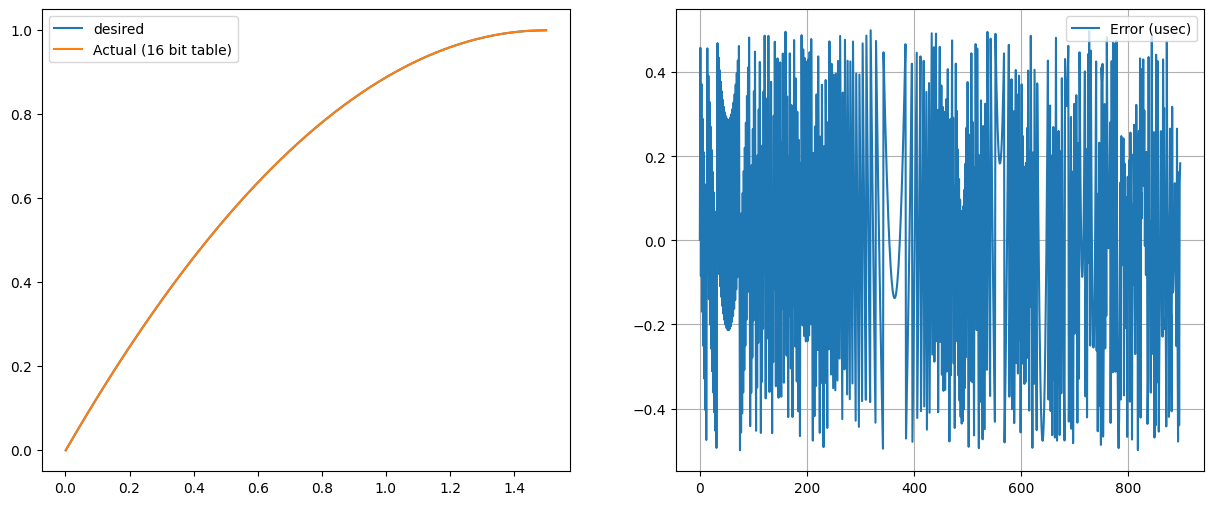

In [7]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plot(np.cumsum(delays/1000000),np.linspace(0,1,len(delays)),
     '-', label='desired')
plot(np.cumsum(intervals_recon/1000000),
     np.linspace(0,1,len(intervals_recon)), '-', label='Actual (16 bit table)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(delays-intervals_recon, label='Error (usec)')
plt.legend()
plt.grid()

In [8]:
import datetime
    
fil=open('lookup_table2.h','wt')
fil.writelines('//%s\n'%datetime.datetime.now())
fil.writelines('const unsigned int table2_info[] = {\n')
fil.writelines('\t%d, //num_steps\n'%num_steps);
fil.writelines('\t%d, //const unsigned int table_scaler = ;\n'%scaler_expanded);
fil.writelines('\t%d, //const unsigned int table_expander_exponent = ;\n'%expander_exponent);
fil.writelines('\t%d}; //const unsigned int table_interval_min = };\n'%interval_min);
fil.writelines('const PROGMEM uint16_t table2[] = {\n');
for nelement in intervals:
    fil.writelines('%d,\n'%nelement)
fil.writelines('};\n');
fil.close()

# In reverse:
fil=open('lookup_table2r.h','wt')
fil.writelines('//%s\n'%datetime.datetime.now())
fil.writelines('const unsigned int table2r_info[] = {\n')
fil.writelines('\t%d, //num_steps\n'%num_steps);
fil.writelines('\t%d, //const unsigned int table_scaler = ;\n'%scaler_expanded);
fil.writelines('\t%d, //const unsigned int table_expander_exponent = ;\n'%expander_exponent);
fil.writelines('\t%d}; //const unsigned int table_interval_min = };\n'%interval_min);
fil.writelines('const PROGMEM uint16_t table2r[] = {\n');
for nelement in intervals[::-1]:
    fil.writelines('%d,\n'% (nelement) )
fil.writelines('};\n');
fil.close()

if np.max(intervals)>2**16:
    print("Problem, exceeded 16-bit table.")
else:
    print("Ok. Please close/reopen Arduino IDE and recompile")
    print( datetime.datetime.now() )

Ok. Please close/reopen Arduino IDE and recompile
2023-07-06 10:39:33.402859
